In [1]:
from fenics import *
from mshr import *
from dolfin import *
import matplotlib.pyplot as plt
from ISHE_constants_Bi2Se3_variable import *

ZeroDivisionError: float division by zero

In [6]:
import scipy.integrate as integrate
import scipy.special as special
result = integrate.quad(lambda x: special.jv(2.5,x), 0, 4.5)

In [7]:
from numpy import sqrt, sin, cos, pi
I = sqrt(2/pi)*(18.0/27*sqrt(2)*cos(4.5) - 4.0/27*sqrt(2)*sin(4.5) +
                sqrt(2*pi) * special.fresnel(3/sqrt(pi))[0])
print(abs(result[0]-I))

1.0375700298936863e-11


In [3]:
import pint

In [69]:
# assume the Fermi energy is in the mid gap
Ec = Eg0_e
Ef = Eg0_e+0.2
energyArray = np.arange(Ec, 1, 0.001)
N_C_factor = 4 * pi * (2 * m_e * kB * T)**1.5/h**3 * math.exp(-(Ec-Ef)/(kBT_e)) 
density_array = []
for _E in energyArray:
    result = N_C_factor * integrate.quad(lambda x: ((x-Ec)/kBT_e)**0.5 * exp(-(x-Ec)/kBT_e), Ec, _E)[0]
    density_array.append(result)

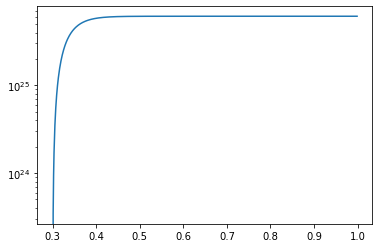

In [70]:
plt.yscale("log")
plt.plot(energyArray, density_array)

In [1]:
from ISHE_constants_Bi2Se3_variable import *
print(f"{EC_EF=}")


print(f"{N_A_bar=}")
print(f"{n_i_bar=}")
print(f"{sigma_bar=}")
print(f"{alpha_bar=}")
print(f"{D_n_bar=}")
print(f"{D_p_bar=}")
print(f"{t_pn_bar=}")
print(f"{t_pp_bar=}")
print(f"{V_scale_factor=}")
print(f"{Vbh_l_bar=}")
print(f"{Vbh_r_bar=}")
print(f"{V_SD_bar=}")

EC_EF=0.0010646226491811824
N_A_bar=0.0
n_i_bar=0.0053209882735709485
sigma_bar=0.02
alpha_bar=10.0
D_n_bar=4.2936328125000005e-07
D_p_bar=4.2936328125000005e-07
t_pn_bar=6026365.348399247
t_pp_bar=6026365.348399247
V_scale_factor=1.659375e-05
Vbh_l_bar=-4.978125e-06
Vbh_r_bar=-4.978125e-06
V_SD_bar=0.0


In [5]:
# Read mesh from file
rectangle = Rectangle(Point(0, 0), Point(1.0, 1.0))
mesh = generate_mesh(rectangle, 500)
# mesh = UnitSquareMesh(50, 50)

In [6]:
# Define function space for system of concentrations
P1 = FiniteElement("P", triangle, 1)
element = MixedElement([P1, P1, P1])
V_space = FunctionSpace(mesh, element)

# Define test functions
v_1, v_2, v_3 = TestFunctions(V_space)

# Define functions for f amd g
u = Function(V_space)

# Split system functions to access components
n_bar, p_bar, V_bar = split(u)
# f, g, h = split(u)

In [9]:
# Define boundaries
right   = f'near(x[0], 1.0)'
left    = 'near(x[0], 0.0)'

# Define boundary conditions
"""
Boundary Conditions For n
"""
bc_n_left_expr = Expression("n_i_bar * exp((Eg0_e/2 - Vbh_l)/kBT_e)",
                                   n_i_bar=n_i_bar, Eg0_e=Eg0_e, Vbh_l=Vbh_l, kBT_e=kBT_e,
                                   degree=0)
bc_n_right_expr = Expression("n_i_bar * exp((Eg0_e/2 - Vbh_r)/kBT_e)", \
                                   n_i_bar=n_i_bar, Eg0_e=Eg0_e, Vbh_r=Vbh_r, kBT_e=kBT_e, \
                                   degree=0)
bc_n_left   = DirichletBC(V_space.sub(0), bc_n_left_expr, left)
bc_n_right  = DirichletBC(V_space.sub(0), bc_n_right_expr, right)

"""
Boundary Conditions For p
"""
bc_p_left_expr = Expression("n_i_bar * exp(-(Eg0_e/2 - Vbh_l)/kBT_e)", \
                                   n_i_bar=n_i_bar, Eg0_e=Eg0_e, Vbh_l=Vbh_l, kBT_e=kBT_e, degree=0)

bc_p_right_expr = Expression("n_i_bar * exp(-(Eg0_e/2 - Vbh_r)/kBT_e)", \
                                   n_i_bar=n_i_bar, Eg0_e=Eg0_e, Vbh_r=Vbh_r, kBT_e=kBT_e, degree=0)
bc_p_left   = DirichletBC(V_space.sub(1), bc_p_left_expr, left)
bc_p_right  = DirichletBC(V_space.sub(1), bc_p_right_expr, right)

"""
Boundary Conditions For V
"""
bc_V_left_expr  = Expression("-Vbh_l_bar + V_SD_bar", Vbh_l_bar=Vbh_l_bar, V_SD_bar=V_SD_bar, degree=0)
bc_V_right_expr = Expression("-Vbh_r_bar", Vbh_r_bar=Vbh_r_bar, degree=0)
bc_V_left   = DirichletBC(V_space.sub(2), bc_V_left_expr, left)
bc_V_right  = DirichletBC(V_space.sub(2), bc_V_right_expr, right)

bc_array = [bc_n_left, bc_n_right, \
            bc_p_left, bc_p_right, \
            bc_V_left, bc_V_right]

In [10]:
x0_bar = 2.0/a

def G0_factor(mu):
#     return (eps0*1e6) * epsr / ((Az * 1e-12) * (mu * 1e-4) * (N_D * 1e18)**2 * e) 
    return eps0 * epsr / (Az * mu * N_D**2 * e) * 1e-8 

def setGeneration(P_L):
    G0_bar = (P_L/(hv*e))/(np.sqrt(2*np.pi)*sigma) * G0_factor(mu_n) 
    G = Expression("G0_bar * exp(-pow((x[0]-x0_bar), 2)/(2*pow(sigma_bar,2)))" +
                   "*exp(-alpha_bar*(1-x[1]))",\
                    G0_bar=G0_bar, x0=x0_bar, sigma_bar=sigma_bar, alpha_bar=alpha_bar, degree=4)
    return G

In [12]:
# G = G0/Az * np.exp(-(x-x0)^2/(2*sigma^2))*exp(-alpha*(1-y))
G_bar = setGeneration(1e-9)
R_n_bar = p_bar / Constant(t_pn_bar)
R_p_bar = p_bar / Constant(t_pp_bar)

In [13]:
n_vec = FacetNormal(mesh)
J_n_bar = n_bar * -grad(V_bar) + Constant(D_n_bar) * grad(n_bar)
J_p_bar = -(p_bar * grad(V_bar) + Constant(D_p_bar) * grad(p_bar))
# first line:    weak form of n part 
# second line:   weak form of p part
# third line:    weak form of V boudnary part
# fourth line:   weak form of V part
F = dot(grad(v_1), J_n_bar) * dx - v_1 * (G_bar - R_n_bar) * dx + \
    dot(grad(v_2), J_p_bar) * dx + v_2 * (G_bar - R_p_bar) * dx + \
    -v_3 * dot(grad(V_bar), n_vec) * ds + \
    dot(grad(v_3), grad(V_bar)) * dx - v_3 * (p_bar - n_bar + Constant(1.0) - Constant(N_A_bar)) * dx # V part

In [14]:
J = derivative(F, u)
problem = NonlinearVariationalProblem(F, u, bc_array, J )
solver  = NonlinearVariationalSolver(problem)
prm = solver.parameters

prm["nonlinear_solver"]="newton"
# prm["newton_solver"]["linear_solver"] = "gmres"
prm["newton_solver"]["linear_solver"] = "mumps"
prm['newton_solver']['maximum_iterations'] = 5000
prm['newton_solver']["relative_tolerance"] = 1e-4
prm["newton_solver"]["absolute_tolerance"]= 1e-4
solver.solve()


(1, True)

In [34]:
f"{n_i*1e12:.3g}"

'5.32e+15'

In [16]:
n = n_bar * N_D * 1e12 # to cm^-3 
p = p_bar * N_D * 1e12 # to cm^-3
V = V_bar * a**2 * e * N_D / (eps0 * epsr)

In [17]:
N_D
-n * (test(nx) * Vx + test(ny) * Vy)  
+ D_n_bar * (nx * test(nx) + ny * test(ny)) 
- test(n) * (G0_bar * exp((x - x0_bar)^2/sigma_bar^2) * exp(alpha_bar * (1 - y)) + p/t_pn_bar)

5000000.0

In [ ]:
-n * (test(nx) * Vx + test(ny) * Vy) 
+ D_n_bar * (nx * test(nx) + ny * test(ny)) 
- test(n) * (G0_bar * exp((x - x0_bar)^2/sigma_bar^2) *  exp(alpha_bar * (1 - y))  
+ p/t_pn_bar) 

Calling FFC just-in-time (JIT) compiler, this may take some time.


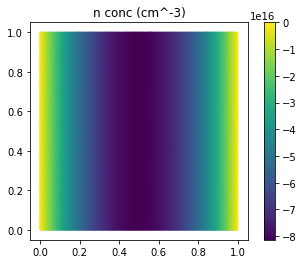

In [18]:
# n_plot = plot(n_bar, title="n conc (cm^-3)", mode='color')
n_plot = plot(n, title="n conc (cm^-3)", mode='color')
plt.colorbar(n_plot)

Calling FFC just-in-time (JIT) compiler, this may take some time.


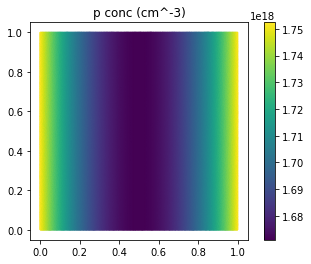

In [19]:
# p_plot = plot(p_bar, title="p conc (cm^-3)", mode='color')
p_plot = plot(p, title="p conc (cm^-3)", mode='color')
plt.colorbar(p_plot)

Calling FFC just-in-time (JIT) compiler, this may take some time.


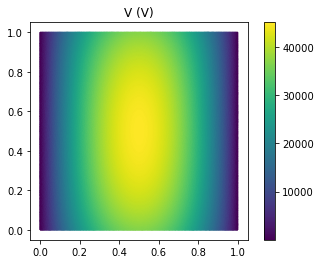

In [20]:
# V_plot = plot(V_bar, title="V conc", mode='color')
V_plot = plot(V, title="V (V)", mode='color')
plt.colorbar(V_plot)

In [ ]:
# vtkfile_n = File("simulation/n.pvd")
# vtkfile_n << project(n, V=V_space)

# vtkfile_p = File("simulation/p.pvd")
# vtkfile_p << project(p, V=V_space)

# vtkfile_V = File("simulation/V.pvd")
# vtkfile_V << project(V, V=V_space)

In [33]:
n

Product(FloatValue(1000000.0), Indexed(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 3), MixedElement(FiniteElement('Lagrange', triangle, 1), FiniteElement('Lagrange', triangle, 1), FiniteElement('Lagrange', triangle, 1))), 14), MultiIndex((FixedIndex(0),))))